# The Packages

In [1]:
# Two models not trained with Eval metrics created

In [2]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [3]:

import statsmodels.api as sm
from datetime import date

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
import tensorflow as tf
import math 
# keras = tf.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [6]:
tf.__version__

'2.10.1'

In [7]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [8]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [9]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

In [10]:
def plotEvaluation(testData, predData, columns):
    testDf = pd.DataFrame(testData, columns = columns)
    predDf = pd.DataFrame(predData, columns = columns)
    plt.figure(figsize=(15,5))
    plt.plot(testDf.Close, label='Real')
    plt.plot(predDf.Close, label='Prediction')

    plt.legend(loc="best")
    #for saving figures
    plt.show()

# The Data

In [11]:
wfc = pd.read_csv('Dataset/Treasury.csv')

In [12]:
wfc.head()

,Date,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
0,2000-01-03,19.56,0,68.61,-4.95,19.56,19.56,19.56,19.56,0.00,0.00,0.00,0.00,50550.00,6050.00
1,2000-01-04,18.59,1,-46.00,-1.01,19.03,19.05,19.07,19.07,0.00,0.00,0.00,0.00,50500.00,6040.00
2,2000-01-05,18.41,2,1.20,4.41,18.78,18.82,18.84,18.85,0.00,0.00,0.00,0.00,50490.00,6051.00
3,2000-01-06,19.22,3,-7.39,1.79,18.92,18.93,18.94,18.94,0.00,0.00,0.00,0.00,50440.00,6046.00
4,2000-01-07,19.56,4,16.11,-3.19,19.11,19.08,19.07,19.07,-0.59,0.00,0.00,0.00,50420.00,6042.00


In [13]:
wfc.Date.dtype

dtype('O')

In [14]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [15]:
wfc.head()

,Date,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
0,2000-01-03,19.56,0,68.61,-4.95,19.56,19.56,19.56,19.56,0.00,0.00,0.00,0.00,50550.00,6050.00
1,2000-01-04,18.59,1,-46.00,-1.01,19.03,19.05,19.07,19.07,0.00,0.00,0.00,0.00,50500.00,6040.00
2,2000-01-05,18.41,2,1.20,4.41,18.78,18.82,18.84,18.85,0.00,0.00,0.00,0.00,50490.00,6051.00
3,2000-01-06,19.22,3,-7.39,1.79,18.92,18.93,18.94,18.94,0.00,0.00,0.00,0.00,50440.00,6046.00
4,2000-01-07,19.56,4,16.11,-3.19,19.11,19.08,19.07,19.07,-0.59,0.00,0.00,0.00,50420.00,6042.00


In [16]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5754 non-null   datetime64[ns]
 1   Close         5754 non-null   float64       
 2   Weekday       5754 non-null   int64         
 3   volumeChange  5754 non-null   float64       
 4   closeChange   5754 non-null   float64       
 5   EMA 10        5754 non-null   float64       
 6   EMA 20        5754 non-null   float64       
 7   EMA 50        5754 non-null   float64       
 8   EMA 100       5754 non-null   float64       
 9   ROC5          5754 non-null   float64       
 10  ROC10         5754 non-null   float64       
 11  ROC15         5754 non-null   float64       
 12  ROC20         5754 non-null   float64       
 13  DTB6          5754 non-null   float64       
 14  DGS5          5754 non-null   float64       
dtypes: datetime64[ns](1), float64(13), int

In [17]:
wfc.describe()

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,2.02,5.93,0.04,36.36,36.34,36.27,36.16,0.05,0.04,0.04,0.04,6689.76,2101.97
std,11.75,1.40,39.58,2.45,11.71,11.68,11.59,11.45,0.99,0.65,0.52,0.43,13368.12,1528.92
min,8.12,0.00,-84.21,-23.82,10.68,12.45,15.86,17.93,-10.67,-6.28,-4.60,-3.39,0.00,0.00
25%,26.74,1.00,-18.62,-0.84,26.76,26.85,26.86,27.03,-0.34,-0.22,-0.16,-0.13,14.00,1045.00
50%,32.64,2.00,-0.81,0.00,32.47,32.43,32.12,31.70,0.04,0.04,0.04,0.04,1012.00,2031.00
75%,47.79,3.00,20.93,0.86,47.87,47.96,48.12,47.94,0.43,0.30,0.25,0.22,4096.00,3068.00
max,65.93,4.00,480.19,32.76,65.12,64.10,61.54,59.00,11.66,7.05,5.18,3.79,60240.00,6083.00


In [18]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
Close,1.000000,0.001747,-0.006274,-0.039838,0.996956,0.993631,0.983874,0.968750,0.004187,0.015491,0.022925,0.026540,-0.439516,-0.398083
Weekday,0.001747,1.000000,-0.098591,-0.017046,0.001691,0.001688,0.001563,0.001403,-0.007323,-0.005586,-0.006370,-0.004390,0.006768,0.010420
volumeChange,-0.006274,-0.098591,1.000000,-0.022412,-0.004357,-0.004683,-0.005411,-0.005978,-0.039711,-0.024530,-0.024136,-0.015871,0.002426,0.002252
closeChange,-0.039838,-0.017046,-0.022412,1.000000,-0.033387,-0.031502,-0.029588,-0.027446,0.422185,0.304658,0.236822,0.207675,0.002199,-0.005255
EMA 10,0.996956,0.001691,-0.004357,-0.033387,1.000000,0.998894,0.991294,0.976955,-0.048146,-0.040130,-0.028623,-0.019722,-0.441711,-0.399340
EMA 20,0.993631,0.001688,-0.004683,-0.031502,0.998894,1.000000,0.995826,0.983434,-0.059152,-0.065863,-0.062123,-0.056749,-0.443600,-0.400658
EMA 50,0.983874,0.001563,-0.005411,-0.029588,0.991294,0.995826,1.000000,0.994964,-0.065505,-0.087485,-0.097548,-0.104024,-0.448769,-0.405436
EMA 100,0.968750,0.001403,-0.005978,-0.027446,0.976955,0.983434,0.994964,1.000000,-0.064271,-0.091319,-0.107953,-0.121656,-0.456469,-0.412816
ROC5,0.004187,-0.007323,-0.039711,0.422185,-0.048146,-0.059152,-0.065505,-0.064271,1.000000,0.655172,0.556507,0.453355,0.007238,-0.000947
ROC10,0.015491,-0.005586,-0.024530,0.304658,-0.040130,-0.065863,-0.087485,-0.091319,0.655172,1.000000,0.773739,0.667275,0.007035,-0.003986


In [19]:
#Dropping Volume for Clearer Scale

# The Split

In [20]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [21]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [22]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [23]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 15)
Train dataset shape: (4313, 15)
Vaid dataset shape: (692, 15)
Test dataset shape: (749, 15)


# Stock Price Graph

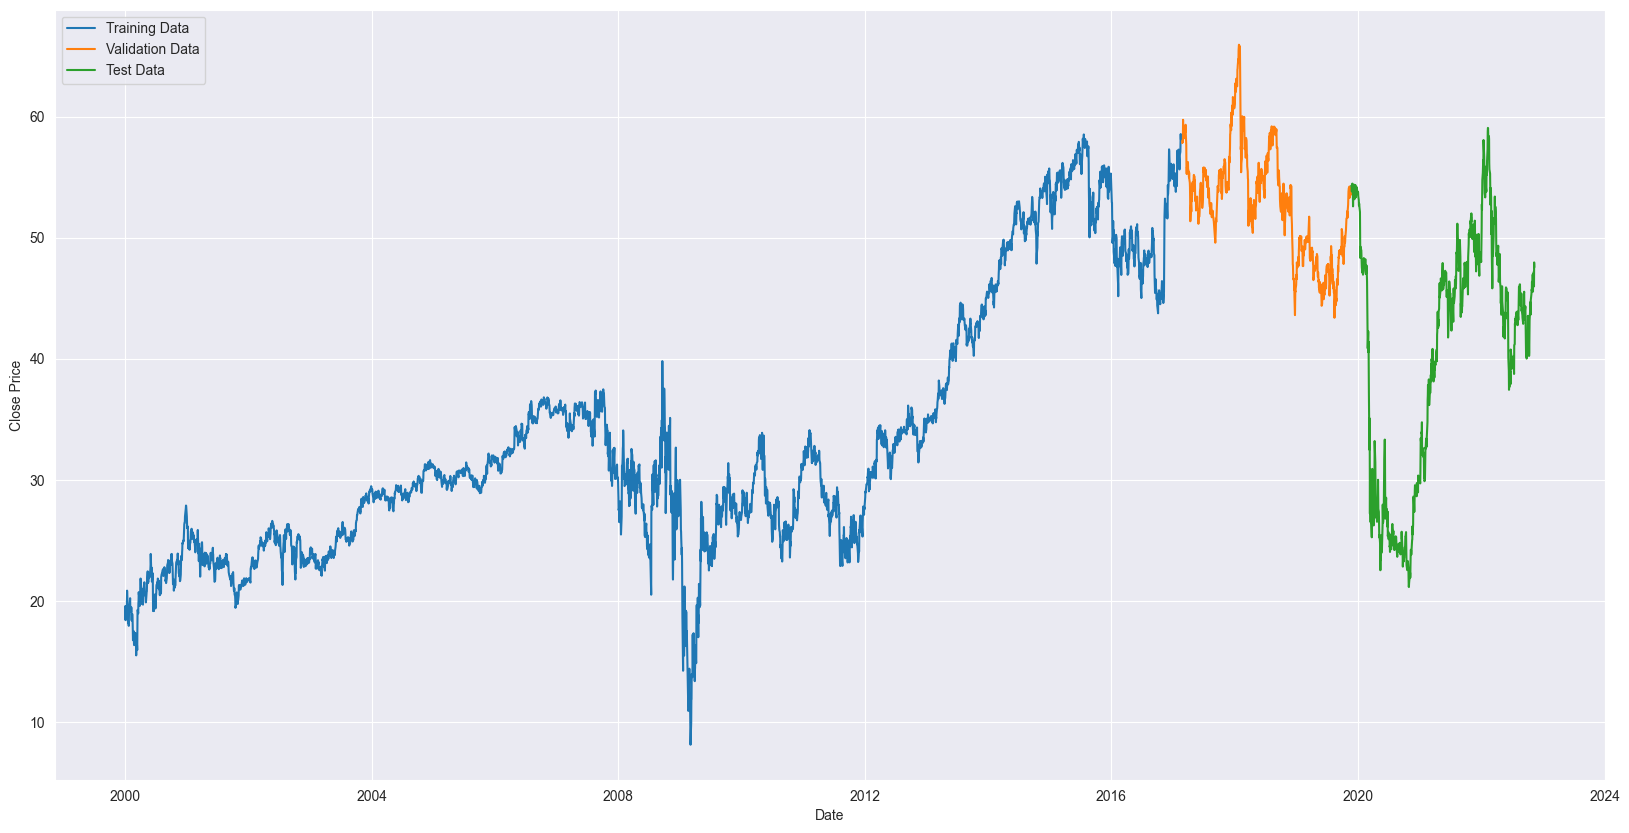

In [24]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

# Feature Engineering

In [25]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [26]:
train_df.head()

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
Date,,,,,,,,,,,,,,
2000-01-03,19.56,0,68.61,-4.95,19.56,19.56,19.56,19.56,0.00,0.00,0.00,0.00,50550.00,6050.00
2000-01-04,18.59,1,-46.00,-1.01,19.03,19.05,19.07,19.07,0.00,0.00,0.00,0.00,50500.00,6040.00
2000-01-05,18.41,2,1.20,4.41,18.78,18.82,18.84,18.85,0.00,0.00,0.00,0.00,50490.00,6051.00
2000-01-06,19.22,3,-7.39,1.79,18.92,18.93,18.94,18.94,0.00,0.00,0.00,0.00,50440.00,6046.00
2000-01-07,19.56,4,16.11,-3.19,19.11,19.08,19.07,19.07,-0.59,0.00,0.00,0.00,50420.00,6042.00


In [27]:
scaler = MinMaxScaler()

trainNorm = scaler.fit_transform(train_df.values)
testNorm = scaler.transform(test_df.values)
validNorm = scaler.transform(valid_df.values)

trainNormDf = pd.DataFrame(trainNorm, columns=train_df.columns)
testNormDf = pd.DataFrame(testNorm, columns=test_df.columns)
validNormDf = pd.DataFrame(validNorm, columns=valid_df.columns)


In [28]:
def splitSequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [29]:
LOOK_BACK = 24
FORECAST_RANGE = 5
n_features = len(trainNormDf.columns)

In [30]:
#Add valid df
Xtrain, Ytrain = splitSequence(trainNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
Xvalid, Yvalid = splitSequence(validNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
Xtest, Ytest = splitSequence(testNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)

In [31]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xvalid.shape)
print(Yvalid.shape)
print(Xtest.shape)
print(Ytest.shape)

(4285, 24, 14)
(4285, 5, 14)
(664, 24, 14)
(664, 5, 14)
(721, 24, 14)
(721, 5, 14)


In [32]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [33]:
def plotMAPEperRange(testData, predData):
    y_test_inverse_time_step  = testData.reshape(int(testData.shape[0]/FORECAST_RANGE), \
                                                      FORECAST_RANGE, testData.shape[-1])
    yhat_inverse_time_step = predData.reshape(int(predData.shape[0]/FORECAST_RANGE), \
                                                  FORECAST_RANGE, predData.shape[-1])
    # yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
    time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
    time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
    for i in range(0, yhat_inverse_time_step.shape[0]):
        for j in range(0, yhat_inverse_time_step.shape[1]):
            time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
            time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
    yhat_time_step = np.array(time_step_list_yhat)
    yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
    y_test_time_step = np.array(time_step_list_y_test)
    y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
    # plotting
    mape_list = []
    for i in range(0, FORECAST_RANGE):
        mape = mape_(y_test_time_step[i], yhat_time_step[i])
        print(mape)
        mape_list.append(mape)
    plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
    plt.xticks((range(0, FORECAST_RANGE)))
    plt.xlabel('Forecast Range')
    plt.ylabel('MAPE')
    

In [34]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)
    

In [35]:
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()
# mae = mae_(y_test_inverse,yhat_inverse)
# # print('mae:', mae)
# mse = mse_(y_test_inverse,yhat_inverse)
# # print('mse:', mse)
# mape = mape_(y_test_inverse,yhat_inverse)
# # print('mape:', mape)

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Multihead CNN LSTM Model

In [37]:
tf.keras.backend.clear_session()

In [38]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)

concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100)(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)
multi_head_cnn_lstm_model.compile(optimizer='adam', loss='mse')

## Tuning Hypertuning LR

In [39]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)


In [41]:
optimizer = Adam(1e-3)
multi_head_cnn_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer = optimizer,
             metrics = ["mae"])


In [42]:
history = multi_head_cnn_lstm_model.fit(Xtrain,Ytrain,batch_size=128, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
34/34 [==============================] - 8s 67ms/step - loss: 0.2181 - mae: 0.4104 - lr: 1.0000e-08
Epoch 2/500
34/34 [==============================] - 2s 68ms/step - loss: 0.2181 - mae: 0.4103 - lr: 1.1220e-08
Epoch 3/500
34/34 [==============================] - 3s 74ms/step - loss: 0.2181 - mae: 0.4103 - lr: 1.2589e-08
Epoch 4/500
34/34 [==============================] - 3s 76ms/step - loss: 0.2181 - mae: 0.4103 - lr: 1.4125e-08
Epoch 5/500
34/34 [==============================] - 3s 74ms/step - loss: 0.2180 - mae: 0.4103 - lr: 1.5849e-08
Epoch 6/500
34/34 [==============================] - 3s 74ms/step - loss: 0.2181 - mae: 0.4103 - lr: 1.7783e-08
Epoch 7/500
34/34 [==============================] - 3s 74ms/step - loss: 0.2181 - mae: 0.4103 - lr: 1.9953e-08
Epoch 8/500
34/34 [==============================] - 3s 74ms/step - loss: 0.2180 - mae: 0.4103 - lr: 2.2387e-08
Epoch 9/500
34/34 [==============================] - 2s 73ms/step - loss: 0.2180 - mae: 0.4103 - lr: 2.5

34/34 [==============================] - 3s 78ms/step - loss: 0.0304 - mae: 0.1253 - lr: 3.9811e-05
Epoch 74/500
34/34 [==============================] - 3s 78ms/step - loss: 0.0283 - mae: 0.1201 - lr: 4.4668e-05
Epoch 75/500
34/34 [==============================] - 3s 78ms/step - loss: 0.0264 - mae: 0.1152 - lr: 5.0119e-05
Epoch 76/500
34/34 [==============================] - 3s 79ms/step - loss: 0.0244 - mae: 0.1101 - lr: 5.6234e-05
Epoch 77/500
34/34 [==============================] - 3s 78ms/step - loss: 0.0226 - mae: 0.1054 - lr: 6.3096e-05
Epoch 78/500
34/34 [==============================] - 3s 77ms/step - loss: 0.0211 - mae: 0.1012 - lr: 7.0795e-05
Epoch 79/500
34/34 [==============================] - 3s 78ms/step - loss: 0.0199 - mae: 0.0973 - lr: 7.9433e-05
Epoch 80/500
34/34 [==============================] - 3s 79ms/step - loss: 0.0191 - mae: 0.0945 - lr: 8.9125e-05
Epoch 81/500
34/34 [==============================] - 3s 78ms/step - loss: 0.0184 - mae: 0.0922 - lr: 1.0000e

34/34 [==============================] - 2s 70ms/step - loss: 0.0380 - mae: 0.1281 - lr: 0.1778
Epoch 147/500
34/34 [==============================] - 3s 74ms/step - loss: 0.0386 - mae: 0.1297 - lr: 0.1995
Epoch 148/500
34/34 [==============================] - 2s 72ms/step - loss: 0.0381 - mae: 0.1282 - lr: 0.2239
Epoch 149/500
34/34 [==============================] - 3s 75ms/step - loss: 0.0381 - mae: 0.1281 - lr: 0.2512
Epoch 150/500
34/34 [==============================] - 3s 77ms/step - loss: 0.0381 - mae: 0.1285 - lr: 0.2818
Epoch 151/500
34/34 [==============================] - 3s 75ms/step - loss: 0.0419 - mae: 0.1363 - lr: 0.3162
Epoch 152/500
34/34 [==============================] - 3s 74ms/step - loss: 0.0387 - mae: 0.1321 - lr: 0.3548
Epoch 153/500
34/34 [==============================] - 3s 79ms/step - loss: 0.0381 - mae: 0.1288 - lr: 0.3981
Epoch 154/500
34/34 [==============================] - 3s 75ms/step - loss: 0.0379 - mae: 0.1283 - lr: 0.4467
Epoch 155/500
34/34 [===

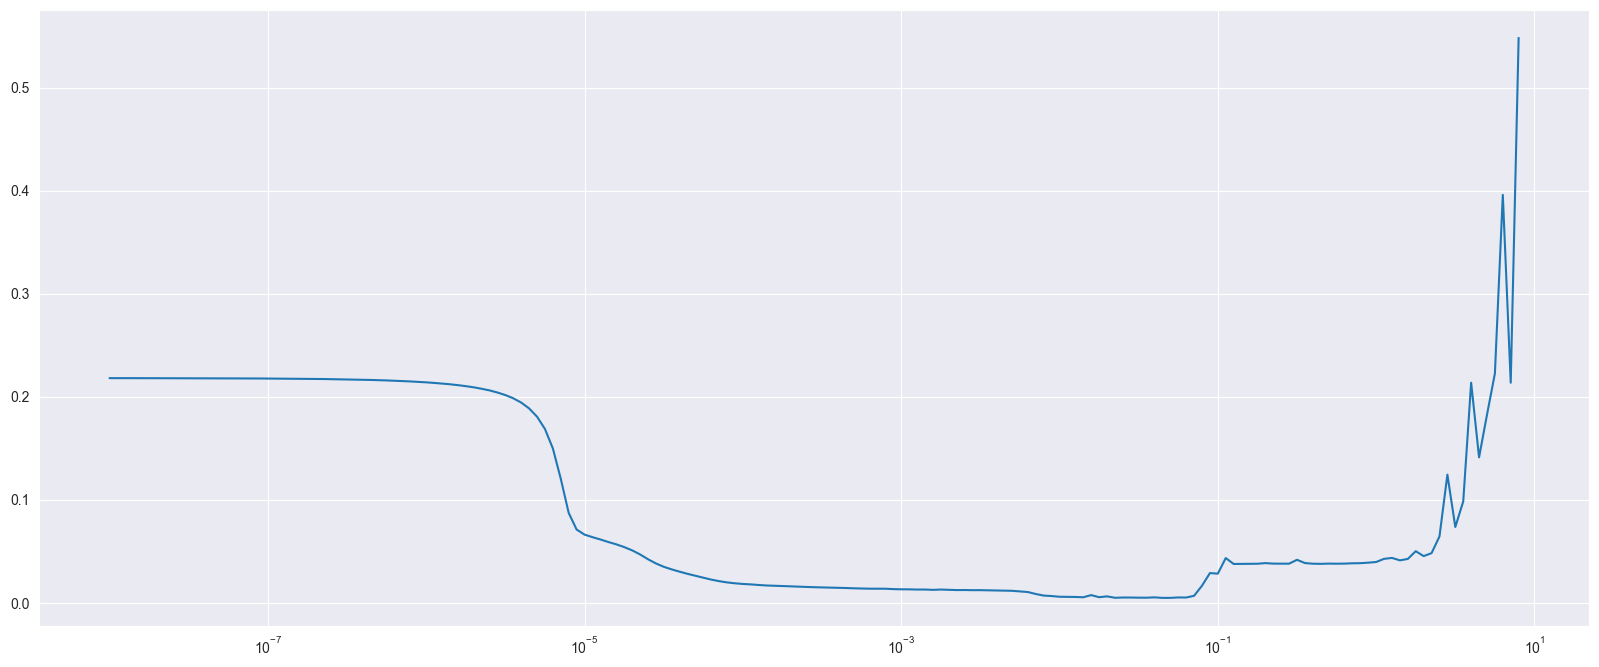

In [43]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])

(0.001, 0.1, 0.0, 0.1)

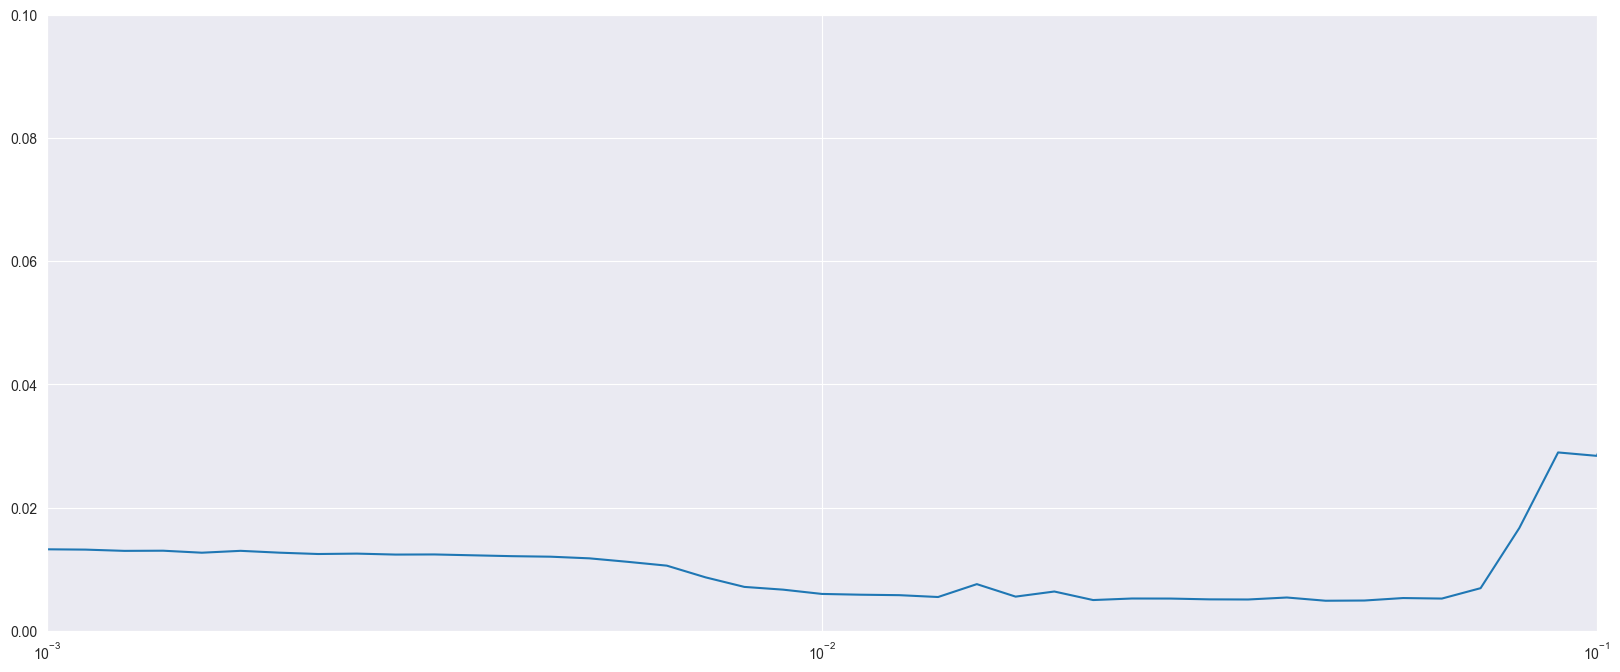

In [45]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-1, 0, 0.1])

## Final Model

In [47]:
multi_head_cnn_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(1e-3),
              metrics=['mae'])

In [48]:
# plot_model(model=model_enc_dec, show_shapes=True)

In [49]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
# model_path = ""
tensorboard_callback = [
#                         tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#                         ModelCheckpoint(model_path, verbose=1, save_best_only=True),
                        ReduceLROnPlateau(monitor='val_mae', factor=0.3,patience=5, min_lr=1e-6, verbose=1),
#                         CSVLogger(csv_path),
                        TensorBoard(),
                        EarlyStopping(monitor= "val_mae", patience=10, restore_best_weights=True)
                       ]

In [50]:
history = multi_head_cnn_lstm_model.fit(Xtrain, Ytrain,batch_size=128, epochs=100, verbose=1,validation_data=(Xvalid, Yvalid), \
                            callbacks=tensorboard_callback)

Epoch 1/100
34/34 [==============================] - 10s 114ms/step - loss: 0.0041 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0376 - lr: 0.0010
Epoch 2/100
34/34 [==============================] - 2s 74ms/step - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0038 - val_mae: 0.0364 - lr: 0.0010
Epoch 3/100
34/34 [==============================] - 3s 75ms/step - loss: 0.0038 - mae: 0.0357 - val_loss: 0.0038 - val_mae: 0.0353 - lr: 0.0010
Epoch 4/100
34/34 [==============================] - 2s 73ms/step - loss: 0.0037 - mae: 0.0354 - val_loss: 0.0037 - val_mae: 0.0353 - lr: 0.0010
Epoch 5/100
34/34 [==============================] - 3s 74ms/step - loss: 0.0037 - mae: 0.0351 - val_loss: 0.0036 - val_mae: 0.0346 - lr: 0.0010
Epoch 6/100
34/34 [==============================] - 3s 76ms/step - loss: 0.0037 - mae: 0.0347 - val_loss: 0.0037 - val_mae: 0.0352 - lr: 0.0010
Epoch 7/100
34/34 [==============================] - 2s 68ms/step - loss: 0.0036 - mae: 0.0343 - val_loss: 0.0035 - val_mae: 0.0

## Keras Score

In [58]:
trainScore = multi_head_cnn_lstm_model.evaluate(Xtrain, Ytrain, verbose=1)
validScore = multi_head_cnn_lstm_model.evaluate(Xvalid, Yvalid, verbose=1)
testScore = multi_head_cnn_lstm_model.evaluate(Xtest, Ytest, verbose=1)

23/23 [==============================] - 0s 9ms/step - loss: 0.0039 - mae: 0.0370


In [59]:
testScore, validScore, trainScore

([0.0038708702195435762, 0.0370241180062294],
 [0.003014274640008807, 0.029631221666932106],
 [0.002667410299181938, 0.024333415552973747])

In [63]:
yhat = multi_head_cnn_lstm_model.predict(Xtest, verbose=0)

In [64]:
predData, testData = inverse_transform(Ytest, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(58.571365, shape=(), dtype=float32)
mse: tf.Tensor(40213.766, shape=(), dtype=float32)
mape: tf.Tensor(1135903400.0, shape=(), dtype=float32)


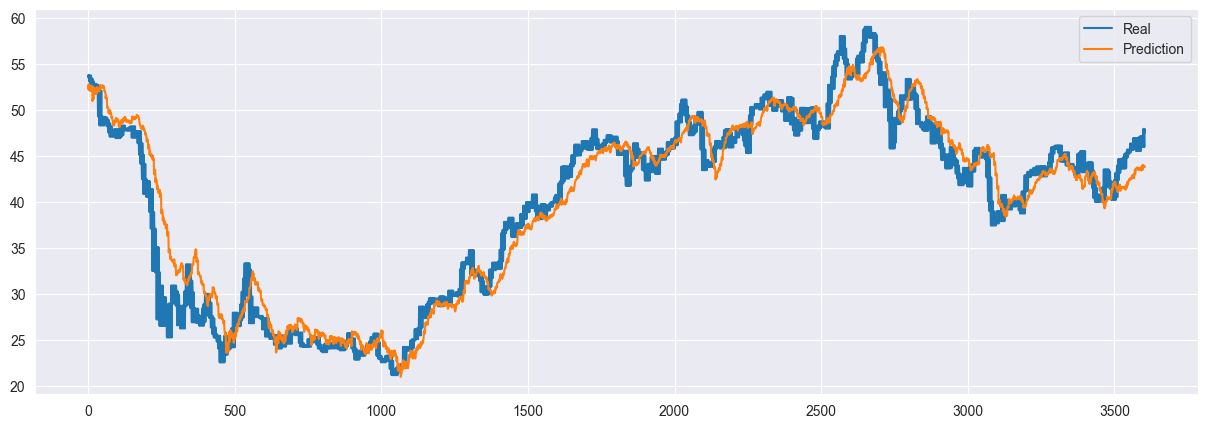

In [65]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Ploting The Evaluation

tf.Tensor(1007188200.0, shape=(), dtype=float32)
tf.Tensor(1086933400.0, shape=(), dtype=float32)
tf.Tensor(1023369000.0, shape=(), dtype=float32)
tf.Tensor(880817700.0, shape=(), dtype=float32)
tf.Tensor(1681208800.0, shape=(), dtype=float32)


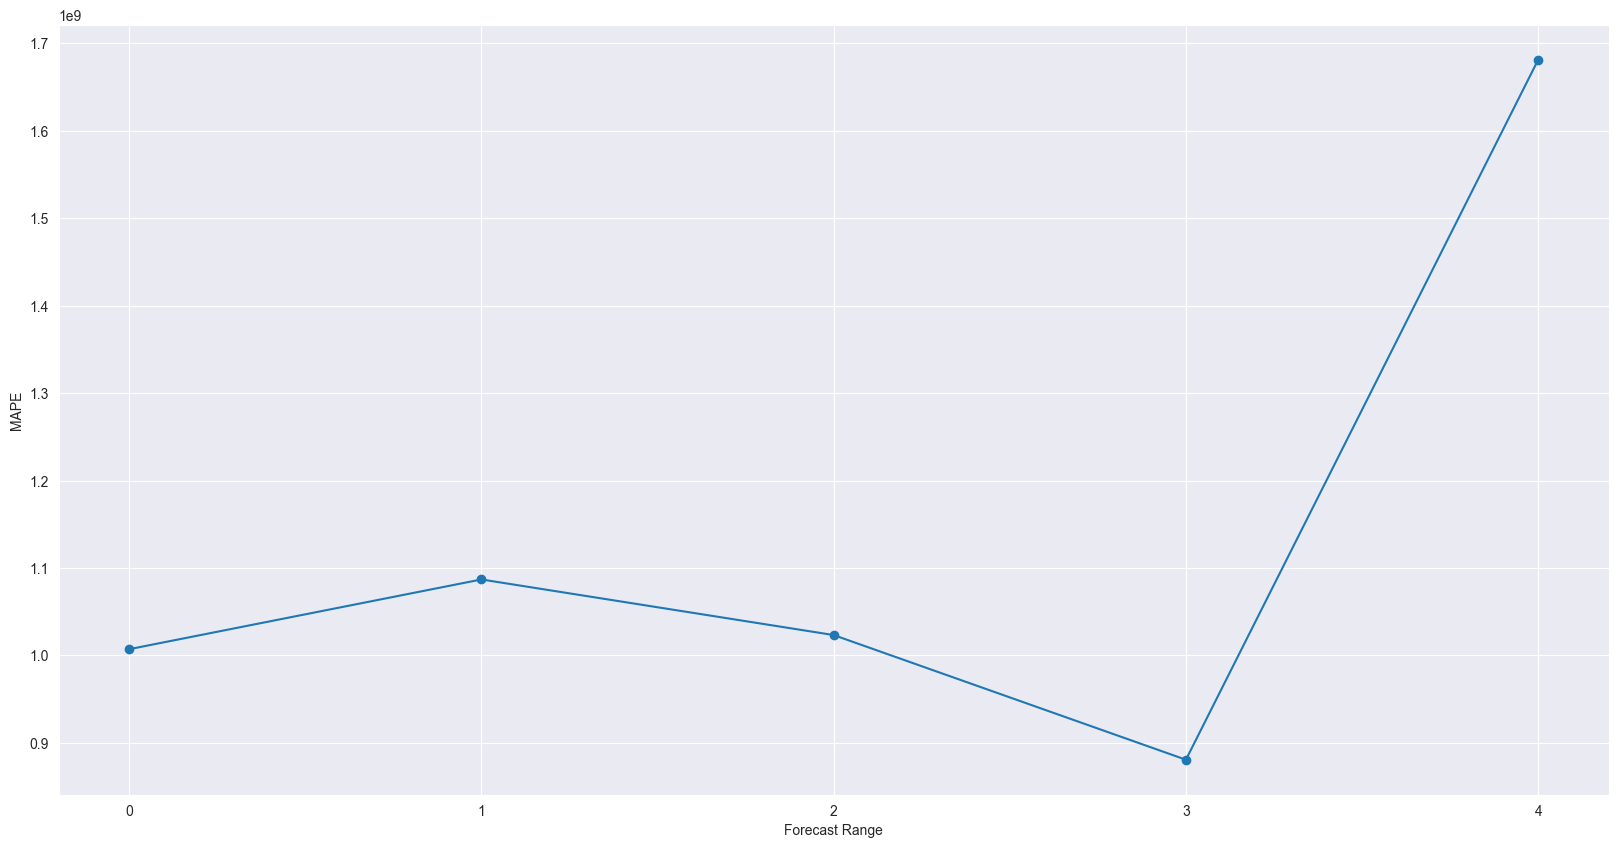

In [66]:
plotMAPEperRange(testData, predData)

In [67]:
def displayMetricsByFeatures(testData, predData, columns):
    for i in range(0, len(columns)):
        print('->', columns[i])
        mae = mae_(testData[:,i],predData[:,i])
        print('mae:', mae)
        mse = mse_(testData[:,i],predData[:,i])
        print('mse:', mse)
        mape = mape_(testData[:,i],predData[:,i])
        print('mape:', mape)

In [68]:
def displayMetricsByColumn(testData, predData, columns, i):

    print('->', columns[i])
    mae = mae_(testData[:,i],predData[:,i])
    print('mae:', mae)
    mse = mse_(testData[:,i],predData[:,i])
    print('mse:', mse)
    mape = mape_(testData[:,i],predData[:,i])
    print('mape:', mape)

In [69]:
displayMetricsByColumn(testData, predData, train_df.columns, 0)

-> Close
mae: tf.Tensor(1.8627146, shape=(), dtype=float32)
mse: tf.Tensor(6.559395, shape=(), dtype=float32)
mape: tf.Tensor(5.0746317, shape=(), dtype=float32)


In [70]:
displayMetricsByFeatures(testData, predData, train_df.columns)

-> Close
mae: tf.Tensor(1.8627146, shape=(), dtype=float32)
mse: tf.Tensor(6.559395, shape=(), dtype=float32)
mape: tf.Tensor(5.0746317, shape=(), dtype=float32)
-> Weekday
mae: tf.Tensor(0.28738454, shape=(), dtype=float32)
mse: tf.Tensor(0.32752675, shape=(), dtype=float32)
mape: tf.Tensor(90425440.0, shape=(), dtype=float32)
-> volumeChange
mae: tf.Tensor(26.760702, shape=(), dtype=float32)
mse: tf.Tensor(1509.1852, shape=(), dtype=float32)
mape: tf.Tensor(317118.16, shape=(), dtype=float32)
-> closeChange
mae: tf.Tensor(2.0155342, shape=(), dtype=float32)
mse: tf.Tensor(8.302617, shape=(), dtype=float32)
mape: tf.Tensor(1881776.1, shape=(), dtype=float32)
-> EMA 10
mae: tf.Tensor(1.1882727, shape=(), dtype=float32)
mse: tf.Tensor(2.6135702, shape=(), dtype=float32)
mape: tf.Tensor(3.2594166, shape=(), dtype=float32)
-> EMA 20
mae: tf.Tensor(0.90978366, shape=(), dtype=float32)
mse: tf.Tensor(1.4434392, shape=(), dtype=float32)
mape: tf.Tensor(2.5273578, shape=(), dtype=float32)
-> 

# WIP

In [71]:
testData[:20,1]

array([0., 1., 3., 4., 0., 1., 3., 4., 0., 1., 3., 4., 0., 1., 2., 4., 0.,
       1., 2., 3.])

In [72]:
predData[:20,1]

array([0.70922107, 1.0380843 , 2.120926  , 3.0733366 , 3.760275  ,
       0.87605304, 1.9485066 , 3.047633  , 3.8749378 , 0.04199588,
       2.0980062 , 3.0757375 , 3.6471486 , 0.18925548, 1.0830363 ,
       3.7347448 , 0.5345811 , 1.2208338 , 2.1180556 , 3.174611  ],
      dtype=float32)

In [73]:
Ytest.shape

(721, 5, 14)

In [74]:
testData.shape

(3605, 14)

In [75]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE


In [76]:
key = 0
testFore1, testFore2, testFore3, testFore4, testFore5 = list(), list(), list(), list(), list()
predFore1, predFore2, predFore3, predFore4, predFore5 = list(), list(), list(), list(), list()
for i in range(testData.shape[0]): #testData.shape(0)
    remainder = i%5
    if remainder == 0:
        testFore1.append(testData[i][key])
        predFore1.append(predData[i][key])
    elif remainder == 1:
        testFore2.append(testData[i][key])
        predFore2.append(predData[i][key])
    elif remainder == 2:
        testFore3.append(testData[i][key])
        predFore3.append(predData[i][key])
    elif remainder == 3:
        testFore4.append(testData[i][key])
        predFore4.append(predData[i][key])
    elif remainder == 4:
        testFore5.append(testData[i][key])
        predFore5.append(predData[i][key])

In [77]:
len(testFore1), len(testFore5), len(predFore1), len(predFore5)

(721, 721, 721, 721)

In [78]:
evalDict = {"testData1" : testFore1, "testData2" : testFore2, "testData3": testFore3, "testData4" : testFore4, \
                  "testData5" : testFore5, "predData1" : predFore1, "predData2" : predFore2, "predData3": predFore3, \
                  "predData4" : predFore4, "predData5" : predFore5}

In [79]:
evaluationDf = pd.DataFrame(evalDict)
evaluationDf.head()

,testData1,testData2,testData3,testData4,testData5,predData1,predData2,predData3,predData4,predData5
0,53.60,53.80,53.75,53.42,53.10,52.60,52.27,52.80,52.67,52.67
1,53.80,53.75,53.42,53.10,52.66,52.12,52.25,52.25,52.15,52.07
2,53.75,53.42,53.10,52.66,52.82,52.63,52.68,52.60,52.60,52.53
3,53.42,53.10,52.66,52.82,52.73,50.98,51.24,51.16,51.41,51.22
4,53.10,52.66,52.82,52.73,52.50,52.31,52.01,52.43,52.20,52.25


In [88]:
def average():
    s = (MAPE(evaluationDf.testData1, evaluationDf.predData1) + MAPE(evaluationDf.testData2, evaluationDf.predData2) + \
    MAPE(evaluationDf.testData3, evaluationDf.predData3) + MAPE(evaluationDf.testData4, evaluationDf.predData4) + \
    MAPE(evaluationDf.testData5, evaluationDf.predData5))/5
    print(s)

In [80]:
MAPE(evaluationDf.testData1, evaluationDf.predData1)

0.04192206832675681

In [81]:
MAPE(evaluationDf.testData2, evaluationDf.predData2)

0.0464696728370514

In [82]:
MAPE(evaluationDf.testData3, evaluationDf.predData3)

0.05074969472777128

In [83]:
MAPE(evaluationDf.testData4, evaluationDf.predData4)

0.05505457544152746

In [84]:
MAPE(evaluationDf.testData5, evaluationDf.predData5)

0.05953559800633685

In [89]:
average()

0.05074632186788876
